# COMPLETED AUTOMATE THE PROCESS 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import joblib

import seaborn as sns

In [5]:
import pandas as pd

# Load the datasets from separate files
file_path = r"completed-iot-datasets.xlsx"

# Load and clean the training dataset
mgh_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
mgh_data.head()



,time,global out,global in,temp in,temp out,rh in,rh out,co2 in,co2 out,toplights,ventilation,heater,Unnamed: 12,Unnamed: 13
0,0,0.032943,0.0,19.806459,22.685000,62.243682,52.775000,409.000000,1530.5,1,0.0,0,dataset3,May
1,300,0.032943,0.0,19.806459,22.685000,62.243682,52.775000,409.000000,1530.5,1,0.0,0,NaN,NaN
2,600,0.032943,0.0,19.889053,22.745000,62.040377,52.510000,409.000000,1506.5,1,0.0,0,NaN,NaN
3,900,0.032943,0.0,20.017409,22.823333,61.694059,52.213333,408.333333,1455.0,1,0.0,0,NaN,NaN
4,1200,0.032943,0.0,20.145762,22.865000,61.322003,52.015000,408.000000,1413.0,1,0.0,0,NaN,NaN


In [6]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def train_and_evaluate_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X = mgh_data[features]
    y = mgh_data[target_variable]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Initialize and fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if flag_train:
        # model = Sequential()
        # model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        # model.add(Dense(32, activation='relu'))
        # model.add(Dense(1))
        
        model = Sequential()
        model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # More neurons
        model.add(Dense(64, activation='relu'))  # Additional hidden layer
        model.add(Dense(32, activation='relu'))  # Additional hidden layer
        model.add(Dense(1))

        # changed adam compare to rmsprop
        model.compile(optimizer='adam', 
                      loss='mean_squared_error', 
                      metrics=['mae', r2_score_metric])

        history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)
        
        # Save the model in the recommended Keras format
        model.save(f'trained-nn-models/{target_variable}_model.keras')

        # Save the scaler
        joblib.dump(scaler, f'trained-nn-models/{target_variable}_scaler.pkl')

        y_hat_test = model.predict(X_test_scaled)
    else:
        # Load the model using the native Keras format
        loaded_model = load_model(f'trained-nn-models/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        
        # Print model summary
        print("\nModel Summary:")
        loaded_model.summary()

        # Count total parameters
        total_params = loaded_model.count_params()
        print(f"Total number of parameters: {total_params}")
        
        # Load the scaler
        scaler = joblib.load(f'trained-nn-models/{target_variable}_scaler.pkl')
        
        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        
        y_hat_test = loaded_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    if flag_train:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')

        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


In [ ]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def train_and_evaluate_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X = mgh_data[features]
    y = mgh_data[target_variable]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Initialize and fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if flag_train:
        # model = Sequential()
        # model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        # model.add(Dense(32, activation='relu'))
        # model.add(Dense(1))
        
        model = Sequential()
        model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # More neurons
        model.add(Dense(64, activation='relu'))  # Additional hidden layer
        model.add(Dense(32, activation='relu'))  # Additional hidden layer
        model.add(Dense(1))

        # changed adam compare to rmsprop
        model.compile(optimizer='adam', 
                      loss='mean_squared_error', 
                      metrics=['mae', r2_score_metric])

        history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)
        
        # Save the model in the recommended Keras format
        model.save(f'trained-nn-models/{target_variable}_model.keras')

        # Save the scaler
        joblib.dump(scaler, f'trained-nn-models/{target_variable}_scaler.pkl')

        y_hat_test = model.predict(X_test_scaled)
    else:
        # Load the model using the native Keras format
        loaded_model = load_model(f'trained-nn-models/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        
        # Print model summary
        print("\nModel Summary:")
        loaded_model.summary()

        # Count total parameters
        total_params = loaded_model.count_params()
        print(f"Total number of parameters: {total_params}")
        
        # Load the scaler
        scaler = joblib.load(f'trained-nn-models/{target_variable}_scaler.pkl')
        
        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        
        y_hat_test = loaded_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    if flag_train:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')

        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.0724 - mae: 0.4714 - r2_score_metric: -1.1931 - val_loss: 0.6848 - val_mae: 0.3773 - val_r2_score_metric: -1472.1526
Epoch 2/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.4867 - mae: 0.3122 - r2_score_metric: 0.0893 - val_loss: 0.4930 - val_mae: 0.3129 - val_r2_score_metric: -2948.2358
Epoch 3/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.5645 - mae: 0.2933 - r2_score_metric: -4.3132 - val_loss: 0.5503 - val_mae: 0.3143 - val_r2_score_metric: -168.7624
Epoch 4/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3948 - mae: 0.2639 - r2_score_metric: 0.4191 - val_loss: 0.4391 - val_mae: 0.2501 - val_r2_score_metric: -447.2302
Epoch 5/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3560 - mae: 0.2437 - r2_score_metric: -33.4839 - val_loss: 0.5630 - val_mae: 0.3257 - val_r2_score_metric: -343.3212
Epoch 6/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.3806 - mae: 0.2529 - r2_sco

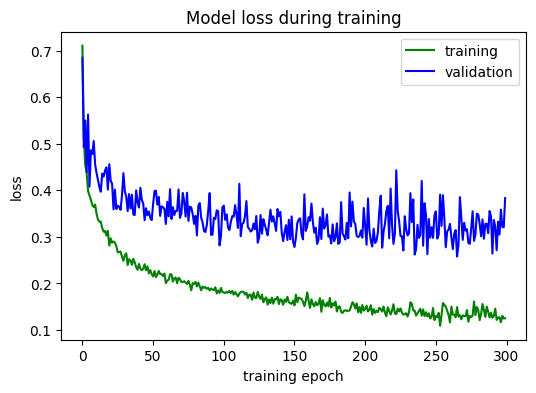

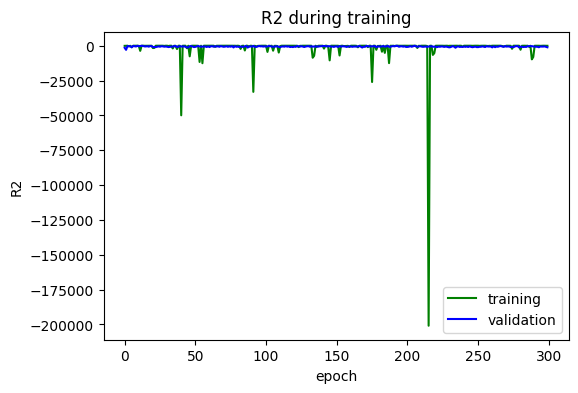

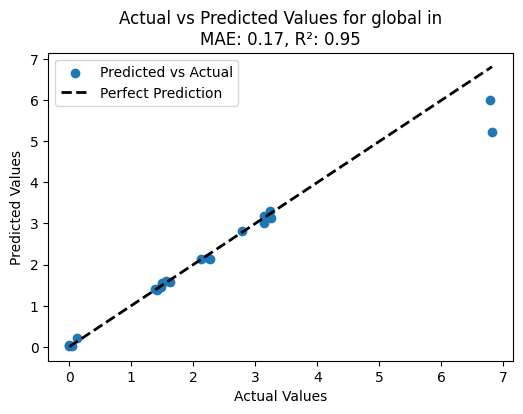

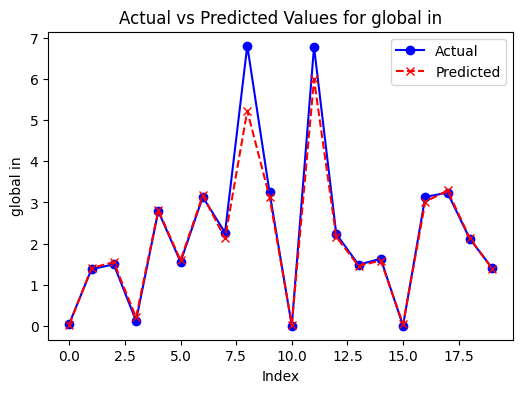

Epoch 1/300


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 35.8697 - mae: 2.6977 - r2_score_metric: -51.8260 - val_loss: 0.2428 - val_mae: 0.2952 - val_r2_score_metric: -377.4500
Epoch 2/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.3145 - mae: 0.3505 - r2_score_metric: 0.5367 - val_loss: 0.2583 - val_mae: 0.3325 - val_r2_score_metric: -2484.2119
Epoch 3/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1940 - mae: 0.3147 - r2_score_metric: 0.6258 - val_loss: 0.5425 - val_mae: 0.4712 - val_r2_score_metric: -4301.1606
Epoch 4/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1851 - mae: 0.3084 - r2_score_metric: 0.5990 - val_loss: 0.2148 - val_mae: 0.2745 - val_r2_score_metric: -452.9745
Epoch 5/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1541 - mae: 0.2809 - r2_score_metric: 0.7033 - val_loss: 0.1511 - val_mae: 0.3018 - val_r2_score_metric: -913.5747
Epoch 6/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1400 - mae: 0.2716 - r2_score_metric: 0.58

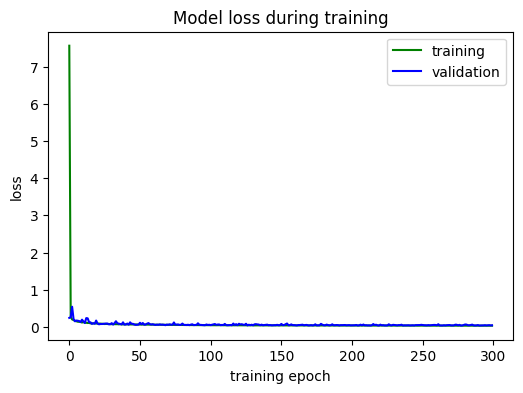

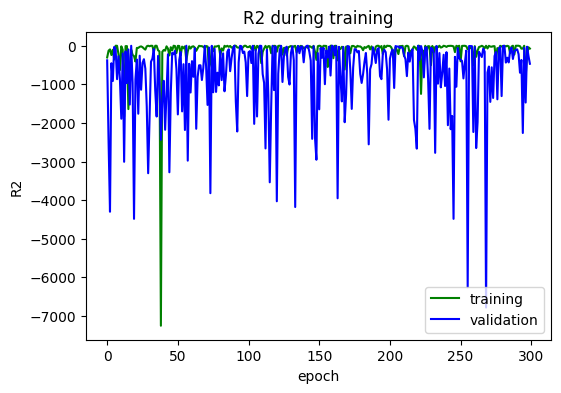

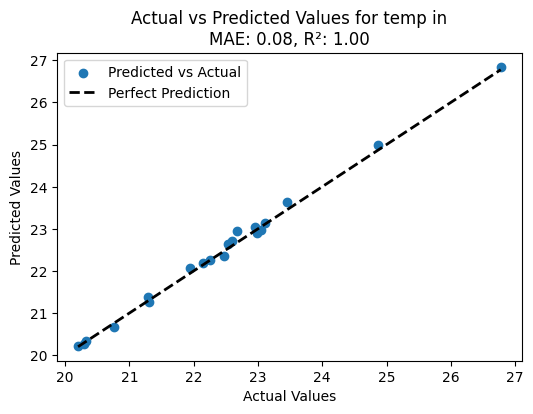

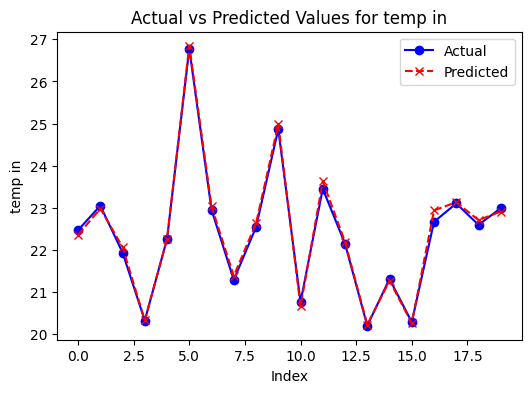

Epoch 1/300


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 240.3345 - mae: 7.0836 - r2_score_metric: -71.5132 - val_loss: 2.1284 - val_mae: 1.0643 - val_r2_score_metric: -601.6820
Epoch 2/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.2903 - mae: 1.1351 - r2_score_metric: -0.1578 - val_loss: 1.5126 - val_mae: 0.8826 - val_r2_score_metric: -458.0609
Epoch 3/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.1145 - mae: 1.0916 - r2_score_metric: 0.7016 - val_loss: 2.4926 - val_mae: 1.2019 - val_r2_score_metric: -10709.7402
Epoch 4/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.0788 - mae: 1.0745 - r2_score_metric: 0.7381 - val_loss: 1.3981 - val_mae: 0.8521 - val_r2_score_metric: -277.5645
Epoch 5/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.7527 - mae: 0.9902 - r2_score_metric: 0.6334 - val_loss: 1.5854 - val_mae: 0.9077 - val_r2_score_metric: -588.7103
Epoch 6/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.7098 - mae: 0.9792 - r2_score_metric: 0.

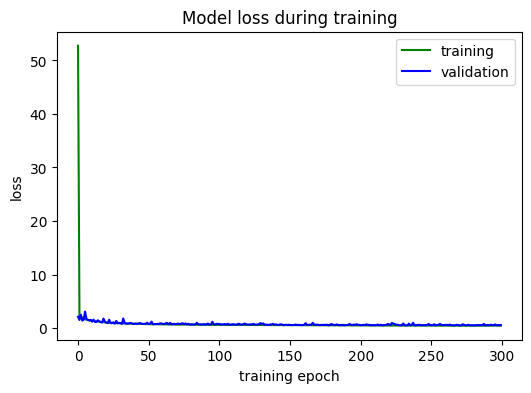

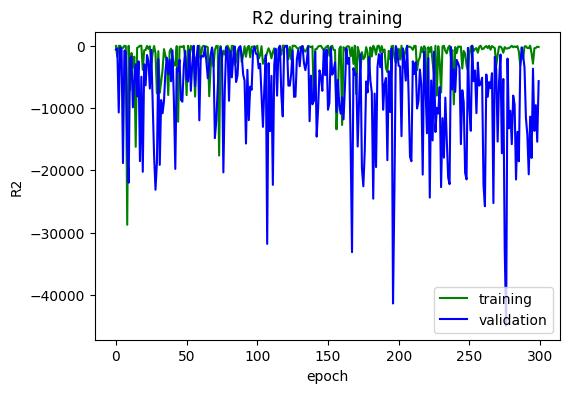

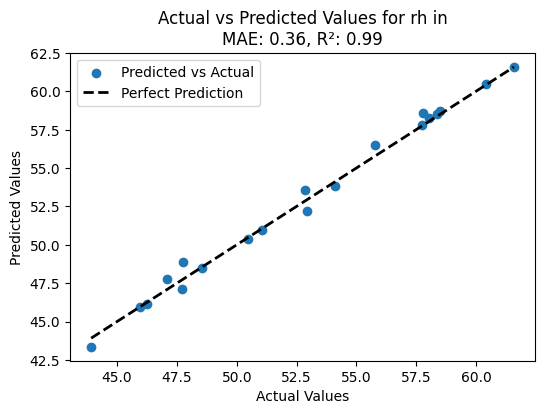

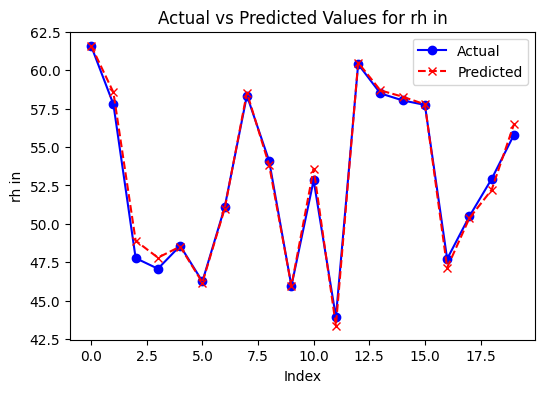

c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 18876.0684 - mae: 65.9103 - r2_score_metric: -244574126080.0000 - val_loss: 55.4620 - val_mae: 3.5692 - val_r2_score_metric: -432209216.0000
Epoch 2/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 306.5399 - mae: 4.6366 - r2_score_metric: -705144448.0000 - val_loss: 56.8173 - val_mae: 2.5579 - val_r2_score_metric: -635907456.0000
Epoch 3/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 121.4292 - mae: 3.7652 - r2_score_metric: -547244608.0000 - val_loss: 35.0727 - val_mae: 2.4990 - val_r2_score_metric: -141766640.0000
Epoch 4/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 371.9090 - mae: 3.6156 - r2_score_metric: -935011904.0000 - val_loss: 34.1690 - val_mae: 2.0214 - val_r2_score_metric: -231419376.0000
Epoch 5/300
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 176.7442 - mae: 3.7046 - r2_score_metric: -539287296.0000 - val_loss: 27.5262 - val_mae: 1.8709 - val_r2_score_metric: -64599472.0000
Epoch

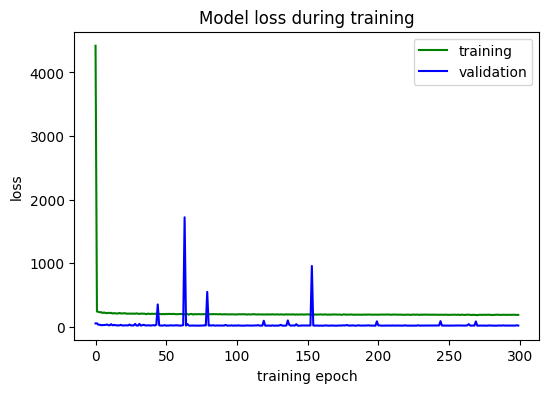

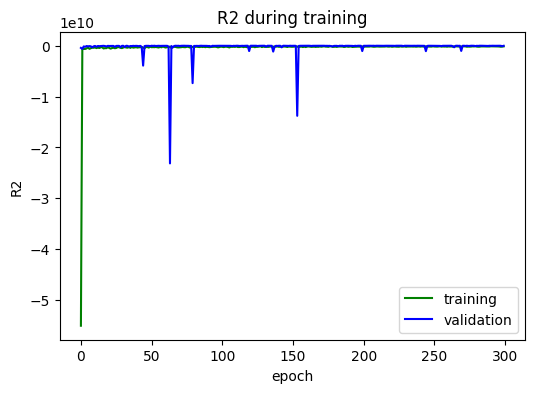

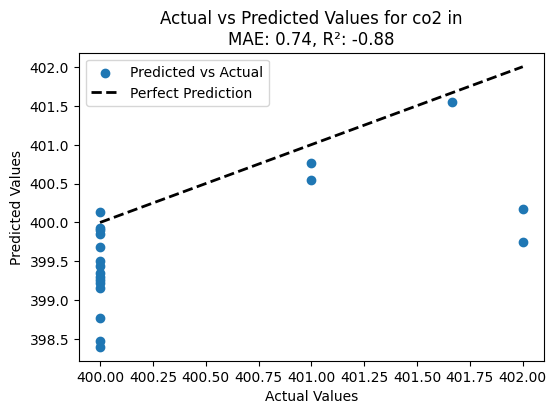

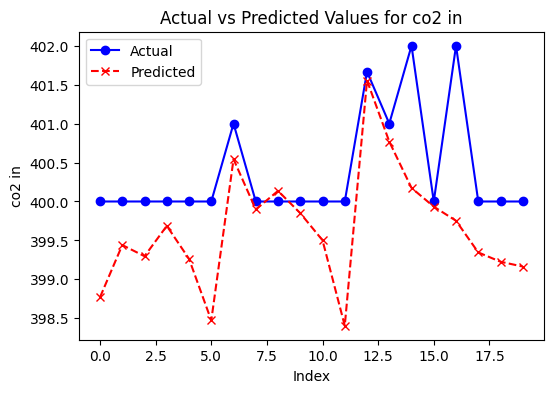

In [7]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    train_and_evaluate_model(target, flag_train = True, _epochs = 300, _batch_size= 4)

In [ ]:
train_and_evaluate_model('temp in', flag_train = False)

# Test with test datasets with trained model


In [8]:
# Load the datasets from separate files
file_path_test = r"test-iot-datasets.xlsx"

# Load and clean the test dataset
mgh_data_test = pd.read_excel(file_path_test)

# Display the first few rows of the cleaned training and test dataframes
print("\nTest Data Sample:")
print(mgh_data_test.head())

num_rows_test = len(mgh_data_test)
print(f'Number of rows test: {num_rows_test}')


Test Data Sample:
   time  global out  global in  temp in  temp out  rh in  rh out  co2 in  \
0  1200    0.000000   0.000000    21.80      22.8  51.65    49.5     400   
1  1500    0.029625   1.354850    22.15      22.7  51.05    49.7     400   
2  1800    0.032943   1.331150    23.35      22.8  48.05    49.2     400   
3  2100    0.032943   1.323250    24.15      23.0  46.05    48.6     400   
4  2400    0.010981   0.439635    24.60      23.0  44.55    48.2     400   

   co2 out  ventilation  toplights  heater  
0      613            0          1       1  
1      619            0          1       1  
2      623            0          1       1  
3      618            0          0       1  
4      602            0          0       1  
Number of rows test: 60


In [9]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def test_model(target_variable):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X_test = mgh_data_test[features]
    y_test = mgh_data_test[target_variable]

    # Load the model using the native Keras format
    loaded_model = load_model(f'trained-nn-models/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
    
    # Load the scaler
    scaler = joblib.load(f'trained-nn-models/{target_variable}_scaler.pkl')
    
    # Scale the test data
    X_test_scaled = scaler.transform(X_test)
    
    y_hat_test = loaded_model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

test_model(target_variable = target_variables[1])

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

test_model(target_variable = target_variables[2])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E419411510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Target Variable: global in
MAE: 0.60
R²: 0.90


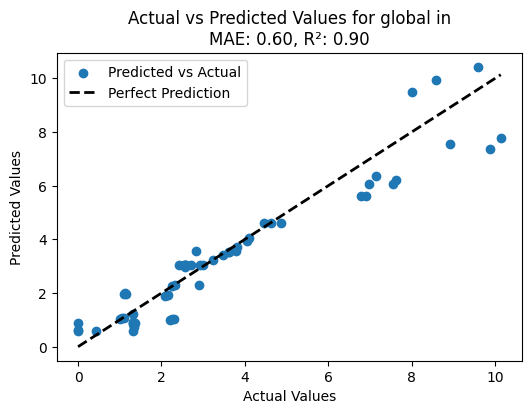

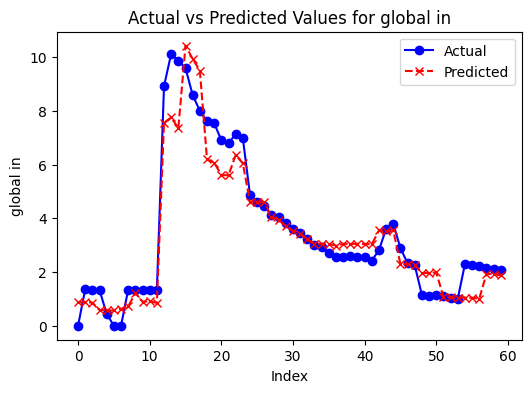

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Target Variable: temp in
MAE: 0.91
R²: 0.79


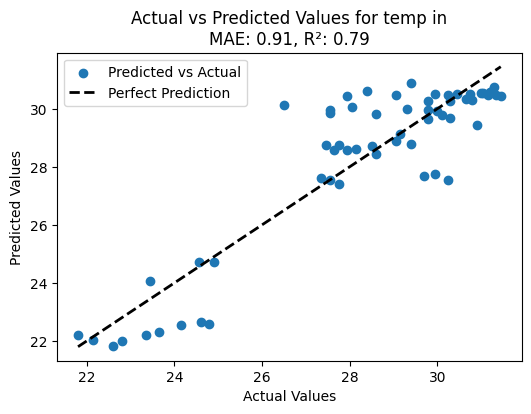

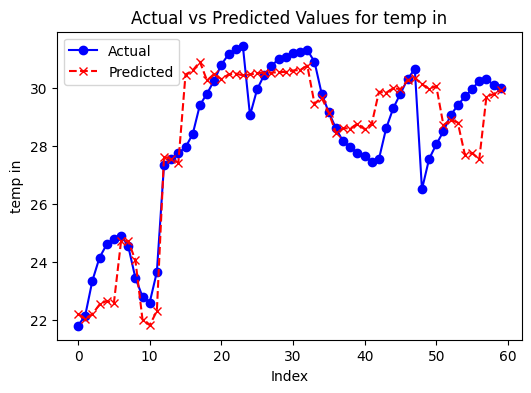

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Target Variable: rh in
MAE: 3.49
R²: -0.44


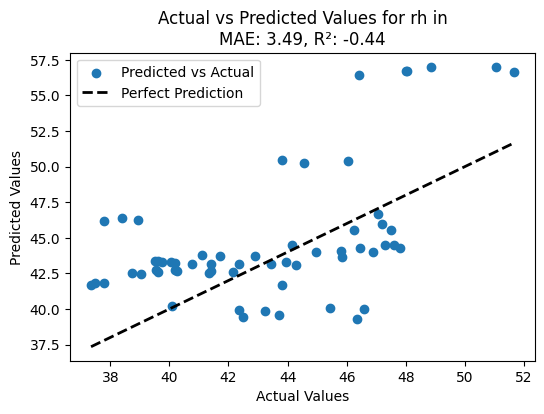

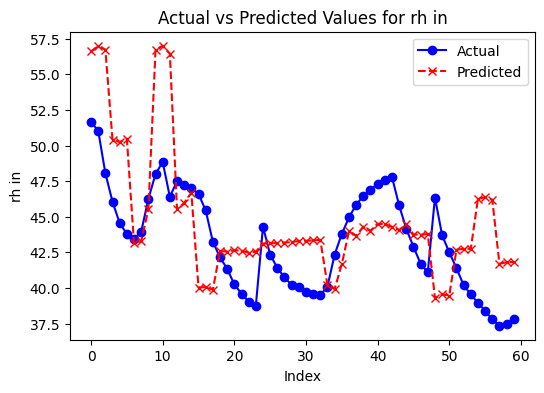

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Target Variable: co2 in
MAE: 9.20
R²: 0.00


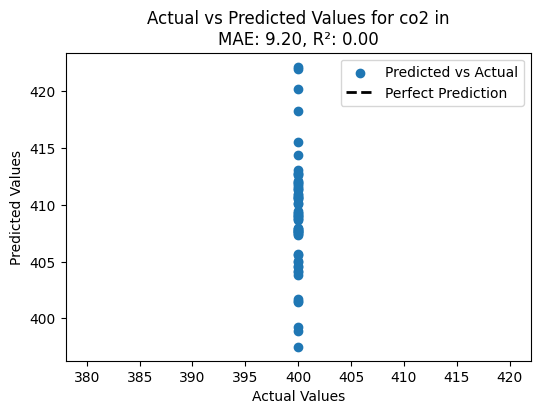

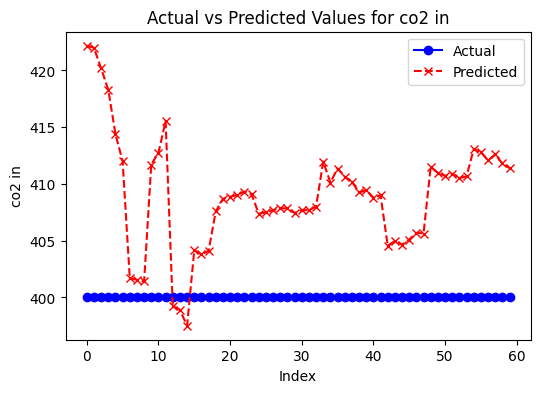

In [10]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    test_model(target)

# AUTOMATE THE PROCESS 

Separate between the training and test datasets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [ ]:
import pandas as pd

# Load the datasets from separate files
file_path_training = r"train-iot-datasets.xlsx"
file_path_test = r"test-iot-datasets-compiled-2-converted.xlsx"

# Load and clean the training dataset
mgh_data_training = pd.read_excel(file_path_training)
#mgh_data_training = mgh_data_training.dropna()  # Drop rows with missing values

# Load and clean the test dataset
mgh_data_test = pd.read_excel(file_path_test)
#mgh_data_test = mgh_data_test.dropna()  # Drop rows with missing values

# Display the first few rows of the cleaned training and test dataframes
print("Training Data Sample:")
print(mgh_data_training.head())

print("\nTest Data Sample:")
print(mgh_data_test.head())

# Length of dataset
num_rows_training = len(mgh_data_training)
print(f'\nNumber of rows training: {num_rows_training}')

num_rows_test = len(mgh_data_test)
print(f'Number of rows test: {num_rows_test}')

# Show all rows and columns of the test dataframe
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns

# print("\nFull Test Data:")
# print(mgh_data_test)

# # Reset options to default
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')


In [ ]:
def train_and_evaluate_model(target_variable, _epochs=100, _batch_size=10):
    # Select features and target variable for training and test data
    features = ['time', 'global out', 'temp out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    # Training data
    X_train = mgh_data_training[features]
    y_train = mgh_data_training[target_variable]
    
    # Test data
    X_test = mgh_data_test[features]
    y_test = mgh_data_test[target_variable]

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the ANN model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    # model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(loss='mse', metrics=['mae', 'R2Score'], optimizer='rmsprop')

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

    # Make predictions on the test set
    y_hat_test = model.predict(X_test_scaled)

    # Calculate MAE and R² score
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    # Plot loss (MSE) for both training and validation split
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
    plt.title('Model loss during training')
    plt.ylabel('loss')
    plt.xlabel('training epoch')
    plt.legend(loc='upper right')
    
    # Plot R2 for both training and validation split
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=history.epoch, y=history.history['R2Score'], color='g', label='training')
    sns.lineplot(x=history.epoch, y=history.history['val_R2Score'], color='b', label='validation')

    plt.title('R2 during training')
    plt.ylabel('R2')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')

    # Print MAE and R²
    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Plotting the test vs predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    # Plot the test vs predicted values in order
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    train_and_evaluate_model(target, 200, 4)